### **Introduction** 

* Over the past four weeks we explored various data preprocessing techniques and solved some regression problems using linear and logistic regression models. The other side of the supervised learning paradigm is **classification problems**.

* To solve such problems we are going to consider **image classification** as a running example and solving it using **Perceptron()** method.


### **Imports**


* For classification problems, we need to import classes and utilities from sklearn.linear_model.

* This module has implementations for different classification models like `Perceptron, LogisticRegression, svm` and `knn`.

* We also need to import a bunch of model selection utilities from `sklearn.model_selection` module and metrics from `sklearn.metrics` module.

* The data preprocessing utilities are imported from `sklearn.preprocessing` modules.


In [1]:
# Common imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ;sns.set()
import os
import io
import warnings

# sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron

from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report

from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV

from pprint import pprint

## **Handwritten Digit Classification**

* We are going to use **Perceptron Classifier** to classify (recognize) given digit images. 

* Since a single perceptron could **only** be used for **binary classification**, we consider only two classes in the first half. Eventually we will extend it to a multi-class setting.

* Suppose we want to recognize whether the given image is of digit zero or not  (digit other than zero). Then the problem could be cast as a binary classification problem.

* The first step is to **create a dataset** that contains a **collection of digit images** (also called examples, samples) written by humans. Then each image should be **labelled** properly.


### **Data Loading**

In [2]:
# returns Data and Label as a pandas dataframe
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

The data matrix $X$ and the respective label vector $ y$ need to be converted to the numpy array by calling a `to_numpy` method.

In [3]:
X = X.to_numpy()
y = y.to_numpy()

Let's get some information like number of features, number of classes about the dataset.

Observe that the labels are of string data type not integers.

In [4]:
target_names = np.unique(y)
print('Number of samples : {0}, type : {1}'.format(X.shape[0], X.dtype))
print('Number of features : {0}'.format(X.shape[1]))

Number of samples : 70000, type : float64
Number of features : 784


In [5]:
print('Minimum : ', np.min(X))
print('Maximum : ', np.max(X))

Minimum :  0.0
Maximum :  255.0


In [6]:
print('Number of classes : {0},type :{1}'.format(len(target_names), y.dtype))
print('Labels : {0}'.format(target_names))

Number of classes : 10,type :object
Labels : ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


* The **MNIST** dataset is clean and the range of values that each feature can take is also known. Therefore, the samples in the dataset may not require many data preprocessing techniques.

* However, it is often better to scale the range of features between 0 to 1.

* So, we can either use `MinMaxScaler` or `MaxAbsScaler`. They don't make any difference as the image pixels can takes only positive value from 0 to 255.

In [7]:
X = MinMaxScaler().fit_transform(X)

print('Minimum : ', np.min(X))
print('Maximum : ', np.max(X))

Minimum :  0.0
Maximum :  1.0


### **Data Visualization**

Let us pick a few images (the images are already shuffled in the dataset) and display them with their respective labels. 

As said above, the images are stacked as a row vector of size $ 1 \times 784$ and therefore must be reshaped to the matrix of size $ 28 \times 28$ to display them properly.

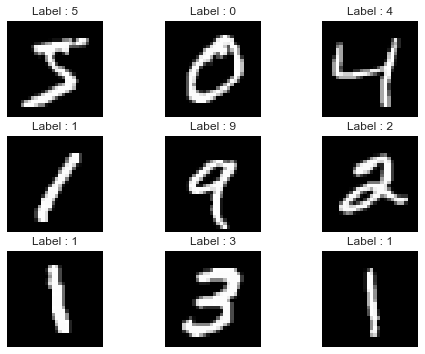

In [8]:
# Choose a square number
num_images = 9  
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor,figsize=(8,6))
# take "num_images" starting from the index "idx_offset"
idx_offset = 0 

for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
    ax[i,j].set_title('Label : {0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

If we closely observe, we can see that there are moderate variations in the appearance of digits (ex: digit 1).

These matrices also close to sparse (i.e, there are lots of zero / black pixels in the matrix than non-zero pixels)

### **Data Splitting**

* Now, we know the details such as number of samples, size of each sample, number of features (784), number of classes (targets) about the dataset.

* So let's split the total number of samples into train and test set in the following ratio : 60000/10000 (i.e 60000 samples in the training set and 10000 samples in the testing set).


* Since the samples in the data set are already randomly shuffled, we need **not to** shuffle it again. Therefore using `train_test_split()` may be skipped.

## **Binary Classification : 0-Detector**

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### **Handling Imbalanced Data**

Before proceeding further, we need to check whether the dataset is balanced or imbalanced. 

We can do it by plotting the distribution of samples in each classes.

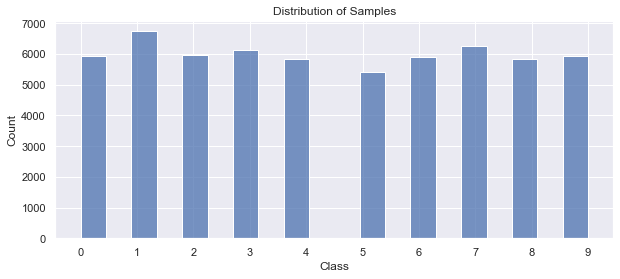

In [10]:
plt.figure(figsize=(10, 4))

sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
           labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

### **Modifying Labels**

* Let us start with a simple classification problem, i.e **binary classification**.

* Since the original label vector contains **10** classes, we need to modify the number of classes to 2.

* Therefore, the label **0** will be changed **1** and all the other labels (1-9) will be changed to **-1**.

* We will name the label vectors as `y_train_0` and `y_test_0`.

In [11]:
# initialize new variable names with all -1
y_train_0 = -1*np.ones(len(y_train))
y_test_0 = -1*np.ones(len(y_test))

# find indices of digit 0 image
indx_0 = np.where(y_train=='0') 

# remember original labels are of type str not int, so use those indices to modify y_train_0 & y_test_0

y_train_0[indx_0] = 1
indx_0 = np.where(y_test =='0')
y_test_0[indx_0] = 1

#### Sanity check :

Let's display the elements of y_train and y_train_0 to verify whether the labels are properly modified.

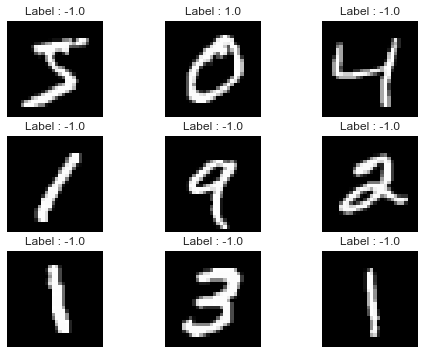

In [12]:
# Choose a square number
num_images = 9  
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor,figsize=(8,6))
# take "num_images" starting from the index "idx_offset"
idx_offset = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title('Label : {0}'.format(str(y_train_0[index+j])))
        ax[i,j].set_axis_off()

## **Model**

### **Baseline Models**

Let us quickly construct a baseline model with the following rule : (you are free to choose different rules)

1. Count number of samples per class.

2. The model **always outputs** the class which has highest number of samples.

3. Then calculate the accuracy of the baseline model.

In [13]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])

print(num_pos)
print(num_neg)

5923
54077


In [14]:
base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(X_train ,y_train_0)

print('Training accuracy : {0:.4f}'.format(base_clf.score(X_train, y_train_0)))
print('Testing accuracy : {0:.4f}'.format(base_clf.score(X_test,y_test_0)))

Training accuracy : 0.9013
Testing accuracy : 0.9020


Now the reason is obvious. The model would have predicted 54077 samples correctly just by outputing -1 for all the input samples. 

Therefore, the accuracy will be simply :  $ \frac{54077}{60000} = 0.90128 $

This is the reason why **"accuracy"** alone is **not always a good** measure!.

### **Perceptron Model**


Quick recap of various components in the general settings:

##### 1. **Training data** 

* consists of features & labels or $(\mathbf X,y)$ 

* Here, $y$ is a **discrete** number from a finite set.

* **Features** in this case are **pixel** values of an image.


##### 2. **Model** : 

\begin{align} 
h_w:y&=&\text g(\mathbf w^T 
\mathbf x) \\ 
&=&\text g(w_0+w_1x_1+\ldots + w_mx_m)
\end{align} 

where,
* $\mathbf w$ is weight vector in $\mathbb{R}^{(m+1)}$ i.e. it has components : $\{w_0,w_1,\ldots,w_m\}$

* g(z) is a non-linear activation function given by a sign function:

$$\text g(z)=\begin{cases} +1 ,\text {if} \ z \ge 0 \\
-1, \text {otherwise}(i.e. z \lt 0)\end{cases}$$

##### 3. **Loss function** : 

Let $ {\hat y}^{(i)} \in \{-1,+1\}$ be the prediction from perceptron and ${\hat y}^{(i)}$ be the actual label for $i-\text{th}$ example. 
$ \\ $

The error is :

$$\text e^{(i)}=\begin{cases} 0 , \ \ \text { if} \ \ {\hat y}^{(i)} = y^{(i)} \\
-\mathbf {w^Tx^{(i)}}y^{(i)}, \text { otherwise} (i.e. {\hat y}^{(i)} \ne y^{(i)})\end{cases}$$

This can be compactly written as:

\begin{equation} 
e^{(i)}=\max(-\mathbf{w^Tx^{(i)}}y^{(i)},0)=\max(-h_{\text w }(\mathbf x^{(i)})y^{(i)},0)
\end{equation} 

##### 4. **Optimization** :

Perceptron learning algorithm :

1. Initialize $\mathbf {\text w}^{(0)}=0$

2. For each training example $(x^{(i)},y^{(i)})$

* ${\hat y}^{(i)}=\text{sign}(\mathbf {w^Tx}^{(i)})[\text {Calculates the output value}]$

* $\mathbf w^{(t+1)} := \mathbf w^{(t)}+ \alpha (y^{(i)}-{\hat y}^{(i)})\mathbf x^{(i)}[\text{Updates the weights}] $

**IMP** : Linearly separable examples lead to convergence of the algorithm with zero training loss, else it oscillates.

#### **Parameters of Perceptron Class**

* Let's quickly take a look into the important parameters of the Perceptron()

class sklearn.linear_model.Perceptron `(*,penalty=None, alpha = 0.0001, l1_ratio=0.15, fit_intercept = True, max_iter=1000,tol=0.001, shuffle=True, verbose=0, eta0=1.0, n_jobs=None, random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5,class_weight=None, warm_start=False).`

* We need not to pay attention to all the arguments and their default values.

* Internally, the API uses the perceptron loss (i.e. it calls **Hinge(0,0)**, where 0.0 is a threshold) and uses SGD to update the weights.

* The other way of deploying perceptron is to use the general `linear_model.SGDClassifier` with `loss='perceptron'`

* The above loss is termed as hard Hinge-loss (as scores pass through the sign function) and hence we can't use SGD.

* Whereas, sklearn implements hinge-loss with the following definition: $\max  (0,-wx^iy^i$) and by default calls SGD to minimize the loss.


#### **Instantiation**

Create an instantiation of binary classifier (bin_clf).

In [15]:
bin_clf = Perceptron(max_iter=100,random_state=1729)

#### **Training and Prediction**

* Call the `fit` method to train the model.

* It would be nice to plot the iteration vs loss curve for the training. However, sklearn does not have a direct function to plot it.

* Nevertheless, we can workaround this using `partial_fit` method (explained later)

In [16]:
bin_clf.fit(X_train, y_train_0)

print('Dimension of Weights : {0}'.format(bin_clf.coef_.shape))
print('Bias : {0}'.format(bin_clf.intercept_))
print('Loss function : {0}'.format(bin_clf.loss_function_))

Dimension of Weights : (1, 784)
Bias : [-108.]
Loss function : <sklearn.linear_model._sgd_fast.Hinge object at 0x0000016D2BEF3570>


Let us make predictions on the training set and then calculate the training accuracy.

In [17]:
y_hat_train_0 = bin_clf.predict(X_train)
print('Training Accuracy :', bin_clf.score(X_train,y_train_0))

Training Accuracy : 0.99095


Let us make the predictions on the test set and then calculate the testing accuracy.

In [18]:
print('Test accuracy :',bin_clf.score(X_test,y_test_0))

Test accuracy : 0.989


#### **Displaying Predictions**
* Take few images from the test-set at random and display it with the corresponding predictions.

* Plot a few images in a single figure window along with their respective **Predictions**. 

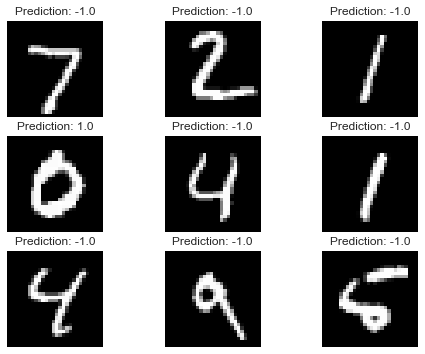

In [19]:
y_hat_test_0 = bin_clf.predict(X_test)

num_images = 9 
factor = int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X_test[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Prediction: {0}'.format(str(y_hat_test_0[index+j])))
        ax[i,j].set_axis_off()

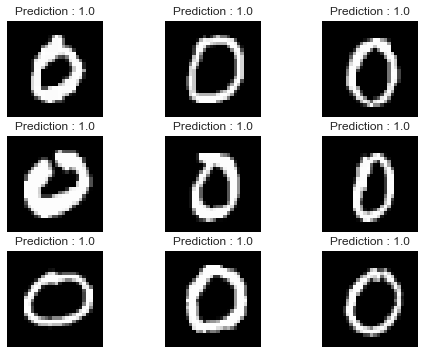

In [20]:
indx_0  = np.where(y_test_0==1)

zeroImgs = X_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]

num_images = 9 
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray') 
        ax[i,j].set_title('Prediction : {0}'.format(str(zeroLabls[index+j])))
        ax[i,j].set_axis_off()

It seems that there are a significant number of images that are correctly classified.

In [21]:
num_misclassified = np.count_nonzero(zeroLabls == -1)
num_correctclassified = len(zeroLabls) - num_misclassified

accuracy = num_correctclassified / len(zeroLabls)
print(accuracy)

0.9193877551020408


* This above score is less than the accuracy score of the model but it seems preety descent.

* Will it be the same if we consider another digit, say, 5 for positive class and all other class as negative. Of course not.


#### **Better Evaluation metrics**
* We now know that using the accuracy **alone** to measure the performance of the model is not suitable (especially for imbalanced datasets).


##### **1. Confusion Matrix**


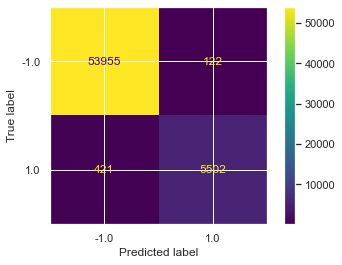

In [22]:
y_hat_train_0 = bin_clf.predict(X_train)

cm_display = ConfusionMatrixDisplay.from_predictions(
    y_train_0, y_hat_train_0, values_format='.5g', display_labels=bin_clf.classes_)
plt.show()

* Pay attention to the number of FPs and FNs. Suppose for some reasons, we want the classifer to avoid FPs to a good extent irrespective of FNs, how can we acheive it.

* To answer it, let's compute the other metrics which take FPs and FNs into account.

##### **2. Precision & Recall**

We can use the function `classification_report` to compute these parameters. 

However, for the time being let's compute these parameters using the data from the confusion matrix manually.

In [23]:
cf_matrix = cm_display.confusion_matrix 

tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [24]:
precision = tp/(tp+fp)
print('Precision : ', precision)

recall = tp/(tp+fn)
print('Recall : ', recall)

accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy : ', accuracy)


Precision :  0.9783072546230441
Recall :  0.9289211548201924
Accuracy :  0.99095


* Precision is close to 0.98. Despite it, we still want to increase the precision.

* In general, we would like to know whether the model under consideration with the set hyper-parameters is a good one for a given problem.

##### **Cross validation (CV)**

* Well to address this, we have to use cross-validation folds and measure the same metrics across these folds for different values of hyperparameters.

* However, perceptron doesn't have many hyperparameters other than the learning rate.

* For the moment, we set the learning rate to its default value. Later, we will use `GridSearchCV` to find the better value for the learning rate.

**Generalization**

In [25]:
bin_clf = Perceptron(max_iter=100, random_state=1729)

scores = cross_validate(bin_clf, X_train, y_train_0, cv=5, scoring=[
                        'precision', 'recall', 'f1'], return_estimator=True)
print(scores)

{'fit_time': array([0.80022049, 1.47012854, 1.06001902, 0.94003081, 1.28021407]), 'score_time': array([0.02770138, 0.02423024, 0.02049136, 0.02981305, 0.02924967]), 'estimator': [Perceptron(max_iter=100, random_state=1729), Perceptron(max_iter=100, random_state=1729), Perceptron(max_iter=100, random_state=1729), Perceptron(max_iter=100, random_state=1729), Perceptron(max_iter=100, random_state=1729)], 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]), 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439]), 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763])}


**NOTE :** 

The perceptron estimator passed as an argument to the function `cross_validate` is internally cloned `num_fold (cv=5)` times and fitted independently on each fold. (you can check this by setting `warm_start=True`)

Compute the average and standard deviation of scores for all three metrics on (k=5) folds to measure the generalization!.


In [26]:
print('Precision : avg : {0:.2f},  std : {1:.2f}'.format(
    scores['test_precision'].mean(), scores['test_precision'].std()))

print()
print('Recall : avg : {0:.2f},  std : {1:.2f}'.format(
    scores['test_recall'].mean(), scores['test_recall'].std()))

print()
print('F1 score : avg : {0:.2f},  std : {1:.3f}'.format(
    scores['test_f1'].mean(), scores['test_f1'].std()))

Precision : avg : 0.96,  std : 0.01

Recall : avg : 0.92,  std : 0.03

F1 score : avg : 0.94,  std : 0.013


* Let us pick the first estimator returned by the cross-validate function.

* So, we can hope that the model might also perform well on test data.

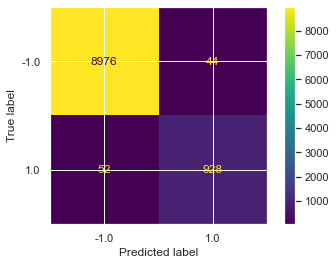

In [27]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(X_test)

cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test_0, y_hat_test_0, values_format='.5g')

In [28]:
print('Precision : {0:.4f}'.format(precision_score(y_test_0, y_hat_test_0)))
print('Recall : {0:.4f}'.format(recall_score(y_test_0, y_hat_test_0)))

Precision : 0.9547
Recall : 0.9469


This is good !

Another way for '**Generalization**' (Optional)

* There is an **another approach** of getting predicted labels via cross-validation and using it to measure the generalization. 

* In this case, each sample in the dataset will be part of only one test set in the splitted folds.

In [29]:
y_hat_train_0 = cross_val_predict(bin_clf, X_train, y_train_0, cv=5)

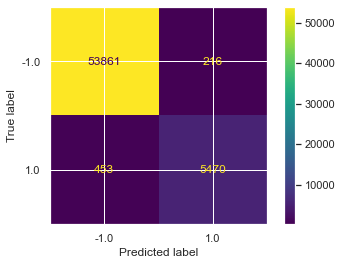

In [30]:
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_train_0, y_hat_train_0, values_format='.5g')
    
plt.show()

In [31]:
cf_matrix = cm_display.confusion_matrix 
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

precision = tp/(tp+fp)
print('Precision : ', precision)

recall = tp/(tp+fn)
print('Recall : ', recall)

accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy : ', accuracy)


Precision :  0.9620119591980303
Recall :  0.9235184872530812
Accuracy :  0.98885


Compare the precision and recall score obtained by the above method with that of the previous method (i.e. using `cross_validate`) 


In [32]:
print('Precision : {0:.4f}'.format(precision_score(y_train_0,y_hat_train_0))) 
print('Recall : {0:.4f}'.format(recall_score(y_train_0,y_hat_train_0)))

Precision : 0.9620
Recall : 0.9235


Finally, we can print all these scores as a report using the `classification_report` function

In [33]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



##### **3. Precision / Recall Tradeoff**

* Often time we need to make a trade off between precision and recall scores of a model.

* It depends on the problem at hand.

* It is important to note that we should **not** pass the **predicted labels** as input to `precision_recall_curve` function, instead we need to pass the probability scores or the output from the decision function!.

* The `Perceptron()` class contains a `decision_function` method, therefore we can make use of it.

* Then, internally the decision scores are sorted, **tps** and **fps** will be computed by changing the threshold from index[0] to index [-1].

* Let us compute the scores from decision function.

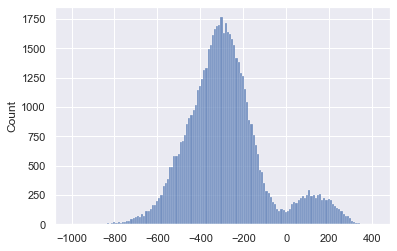

In [34]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(X_train, y_train_0)
y_scores = bin_clf.decision_function(X_train)

sns.histplot(np.sort(y_scores))
plt.show()


The reason for so many negative values than the positives is : **Class-Imbalance**.

* Suppose threshold takes the value of -600, then all the samples having score greater than -600 is set to 1 ( +ve label ) and less than it is set to -1 ( -ve label ).

* Therefore, the number of False Positives will be increased. This will in turn reduce the precision score to a greater extent.

* On the otherhand, if the threshold takes the value of say 400, Then, the number of False negatives will be increase and hence the recall will reduce to a greater extent.


In [35]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0,y_scores,pos_label=1)

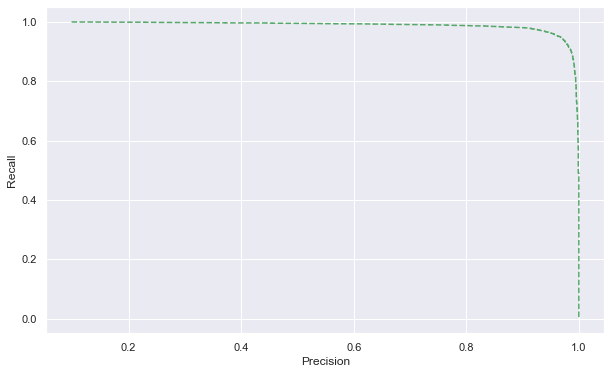

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(precisions[:-1], recalls[:-1], "g--")

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

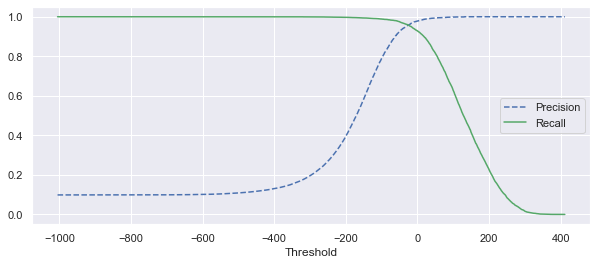

In [37]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
plt.plot(thresholds, recalls[:-1], "g-", label='Recall')

plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='best')
plt.show()

Getting the index of threshold around zero 

In [38]:
idx_th = np.where(np.logical_and(thresholds >0, thresholds <1))
print('Precision for zero threshold : ',precisions[idx_th[0][0]])

Precision for zero threshold :  0.9783072546230441


* **The solution** to the question of how can we increase the precision of the classifier by compromising the recall is we can make use of the above plot.

##### **4. ROC Curve**

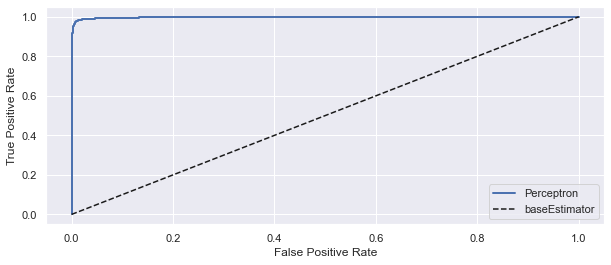

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, linewidth=2, label='Perceptron')
plt.plot([0, 1], [0, 1], 'k--', label='baseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()


#### **Warm Start VS Cold Start**

##### **Cold Start**

* If we execute the `fit` method of `bin_clf` repeatedly, we get the same score for both training and testing accuracy.

* This because everytime the `fit` method is called, the model weights are initialized to the same values. Therefore, we obtain the same score.

* This is termed as **cold start**. 

Let's execute the following cell 4 times and observe the score.

In [40]:
bin_clf.fit(X_train, y_train_0)
y_hat_train_0 = bin_clf.predict(X_train)

print('Training Accuracy : ', bin_clf.score(X_train, y_train_0))
print('Test accuracy : ', bin_clf.score(X_test, y_test_0))

Training Accuracy :  0.99095
Test accuracy :  0.989


##### **Warm Start**

* Setting `warm_start=True` retains the weight values of the model after `max_iter` and hence produce different results for each execution.

* Warm starting is useful in many ways. It helps us train the model by initializing the weight values from the previous state. So, we can pause the training and resume it whenever we get the resource for computation.

* Of course, it is not required for simple models like perceptron and for a small dataset like **MNIST**.

* In this notebook, we use this feature to plot the iteratation vs loss curve.

Let us execute the following lines of code 4 times and observe how the training accuracy changes for each execution.

In [41]:
bin_clf_warm = Perceptron(max_iter=100,random_state=1729,warm_start=True)

In [42]:
bin_clf_warm.fit(X_train,y_train_0)
print('Training Accuracy : ', bin_clf_warm.score(X_train,y_train_0))

Training Accuracy :  0.99095


## **Multiclass Classification (OneVsAll)**

* We know that the perceptron is a binary classifier. However,
MNIST dataset contains 10 classes. So, we need to extend the idea to handle multi-class problem.

* **Solution** : Combining multiple binary classifiers and devise a suitable scoring metric.

* Sklearn makes it extremely easy without modifying a single line of code that we have written for the binary classifier.

* Sklearn does this by counting a number of unique elements (10 in this case) in the label vector `y_train` and converting labels using `Labelbinarizer` to fit each binary classifier.


In [43]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelBinarizer

Let's use **Label binarizer** just to see the encoding.

In [44]:
y_train_ovr = LabelBinarizer().fit_transform(y_train)

for i in range(10):
    print('{0} : {1}'.format(y_train[i],y_train_ovr[i]))

5 : [0 0 0 0 0 1 0 0 0 0]
0 : [1 0 0 0 0 0 0 0 0 0]
4 : [0 0 0 0 1 0 0 0 0 0]
1 : [0 1 0 0 0 0 0 0 0 0]
9 : [0 0 0 0 0 0 0 0 0 1]
2 : [0 0 1 0 0 0 0 0 0 0]
1 : [0 1 0 0 0 0 0 0 0 0]
3 : [0 0 0 1 0 0 0 0 0 0]
1 : [0 1 0 0 0 0 0 0 0 0]
4 : [0 0 0 0 1 0 0 0 0 0]


* The `y_train_ovr` will be of size of size $60000 \times 10$.

* The first column will be (binary) label vector for 0-detector and the next one for 1-Detector and so on.

In [45]:
clf = Perceptron(random_state=1729)
clf.fit(X_train,y_train)

Perceptron(random_state=1729)

* What had actually happened internally was that the API automatically created 10 binary classifiers, converted labels to binary sparse matrix and trained them with the binarized labels.

* During the inference time, the input will be passed through all these 10 classifiers and the highest score among the output from the classifiers will be considered as the predicted class.

* To see it in action, let us execute the following lines of code.

In [46]:
print('Shape of Weight matrix : {0} and bias vector : {1}'.format(
    clf.coef_.shape, clf.intercept_.shape))

Shape of Weight matrix : (10, 784) and bias vector : (10,)


* So it is a matrix of size $ 10 \times 784 $, where each row represents the weights for a single binary classifier.

* Important difference to note is that there is no signum function associated with the perceptron.

* The class of a perceptron that outputs the maximum score for the input sample is considered as the predicted class.

In [47]:
for i in range(10):
    scores = clf.decision_function(X_train[i].reshape(1, -1))
    print(scores)
    print()
    print('The predicted class : ', np.argmax(scores))
    print()
    print('Predicted output : ')
    print(clf.predict(X_train[i].reshape(1, -1)))
    print('-'*20)

[[-281.59403306 -316.86757401 -163.89196463  -29.53201077 -360.15901576
    35.74422145 -281.75632449 -129.84598231 -269.37986928 -232.78886582]]

The predicted class :  5

Predicted output : 
['5']
--------------------
[[ 163.56542868 -383.99440215 -217.57545559 -208.67775471 -341.63012687
  -200.703391   -272.04836601 -265.31963091 -205.48413687 -254.29404075]]

The predicted class :  0

Predicted output : 
['0']
--------------------
[[-333.95381776 -222.07201845 -112.63298731  -31.12224529   41.19340254
  -231.70143791 -294.13151865 -140.55028066 -336.50911188 -242.68656671]]

The predicted class :  4

Predicted output : 
['4']
--------------------
[[-246.03221838   87.48547482  -63.78459054  -88.46945021 -171.87637063
  -160.67975394 -243.45420992 -158.6293887  -130.2792772  -255.97957709]]

The predicted class :  1

Predicted output : 
['1']
--------------------
[[-361.45457901 -208.39195694 -322.6535025  -227.38734333 -109.59223376
  -165.16824298 -231.39936947 -134.96336794 -141

Get the prediction for all training samples.

In [48]:
y_hat = clf.predict(X_train)

Lets display the classification report.

In [49]:
print(classification_report(y_train,y_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.89      0.90      0.90      5958
           3       0.86      0.87      0.87      6131
           4       0.89      0.94      0.91      5842
           5       0.81      0.88      0.85      5421
           6       0.92      0.97      0.94      5918
           7       0.91      0.94      0.92      6265
           8       0.92      0.77      0.84      5851
           9       0.92      0.82      0.87      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



Now let us display the confusion matrix and relate it with the report above.

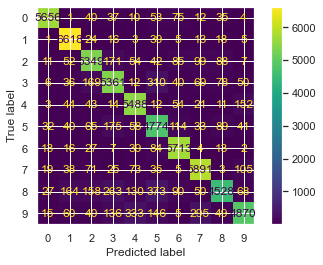

In [50]:
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_train, y_hat, values_format='.5g') 

#### **Making a Pipeline**

* Let's create a pipeline to keep the code compact.

* Recall that, the **MNIST** dataset is clean and hence doesn't require much preprocessing.

* The one potential preprocessing technique we may use is to scale the features within the range(0,1).

* It is **not** similar to scaling down the range values between 0 and 1.

In [51]:
# create a list with named tuples
estimators = [('scaler', MinMaxScaler()), ('bin_clf', Perceptron())]
pipe = Pipeline(estimators)

In [52]:
pipe.fit(X_train,y_train_0)

Pipeline(steps=[('scaler', MinMaxScaler()), ('bin_clf', Perceptron())])

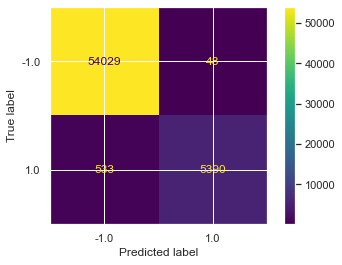

In [53]:
y_hat_train_0 = pipe.predict(X_train)

cm_display = ConfusionMatrixDisplay.from_predictions(
    y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

#### **Iteration vs Loss Curve**

The other way of plotting **Iteration Vs Loss Curve** with the `Partial_fit` method.

In [54]:
iter = 100 
bin_clf1 = Perceptron(max_iter=100,random_state=2094)
loss_clf1=[]

for i in range(iter):
    bin_clf1.partial_fit(X_train,y_train_0,classes=np.array([1,-1])) 
    y_hat_0 = bin_clf1.decision_function(X_train)
    loss_clf1.append(hinge_loss(y_train_0,y_hat_0))

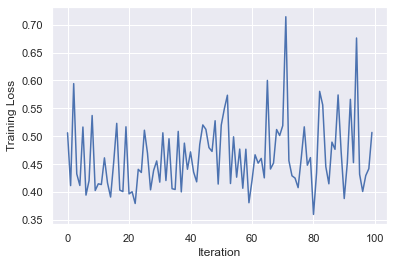

In [55]:
plt.figure()
plt.plot(np.arange(iter), loss_clf1)

plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

#### **GridSearchCV**

* So, far we didn't perform any hyperparameter tuning & just accepted the default value for learning rate of the Perceptron class.

* Now, let us search for a better learning rate using `GridSearchCV`.

* No matter what the learning rate is, the loss will never converge to zero as the classes are not linearly separable.

In [56]:
from sklearn.metrics import make_scorer

scoring = make_scorer(hinge_loss,greater_is_better=False)
lr_grid = [1/2**n for n in range(1,6)]

bin_clf_gscv = GridSearchCV(Perceptron(), param_grid={'eta0':lr_grid},scoring=scoring, cv=5)
bin_clf_gscv.fit(X_train,y_train_0) 

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [57]:
bin_clf_gscv.cv_results_

{'mean_fit_time': array([0.89319444, 0.88571563, 0.85104909, 0.73002439, 0.69517179]),
 'std_fit_time': array([0.19984267, 0.19527222, 0.17349208, 0.09260067, 0.04365529]),
 'mean_score_time': array([0.01677132, 0.01518822, 0.01427217, 0.01503611, 0.01647668]),
 'std_score_time': array([0.00137195, 0.0027181 , 0.00307773, 0.003333  , 0.00319911]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta0': 0.5},
  {'eta0': 0.25},
  {'eta0': 0.125},
  {'eta0': 0.0625},
  {'eta0': 0.03125}],
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.04416667]),
 '

Well, instead of instantiating a Perceptron class with a new learning rate and re-train the model, we could simply get the `best_estimator` from `GridSearchCV` as follows.

In [58]:
best_bin_clf = bin_clf_gscv.best_estimator_
best_bin_clf

Perceptron(eta0=0.125)

We can observe that the best learning rate is **0.125**.

In [59]:
iter = 100
loss = []
best_bin_clf = Perceptron(max_iter=1000,random_state=2094,eta0=0.125)

for i in range(iter):
    best_bin_clf.partial_fit(X_train, y_train_0, classes=np.array([1,-1]))
    y_hat_0 = best_bin_clf.decision_function(X_train)
    loss.append(hinge_loss(y_train_0,y_hat_0))

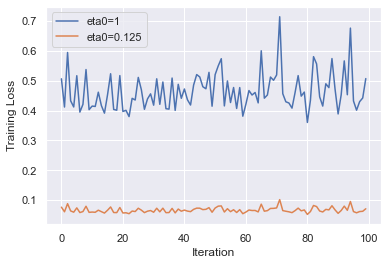

In [60]:
plt.figure()
plt.plot(np.arange(iter), loss_clf1, label='eta0=1')
plt.plot(np.arange(iter), loss, label='eta0=0.125')

plt.grid(True)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

In [61]:
y_hat_train_0 = bin_clf.predict(X_train)
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



Now, compare this classification report with the one when **eta0 = 1**

#### **Visualizing weight vectors** (Optional)

It will be interesting to look into the samples which are misclassified as False Positives (that is, images that are not zero but classified as zero).

In [62]:
# repeating the code for readability
bin_clf = Perceptron(max_iter=100)
bin_clf.fit(X_train, y_train_0)
y_hat_train_0 = bin_clf.predict(X_train)

In [63]:
# index of true -ve samples
idx_n = np.where(y_train_0==-1) 

# index of predicted positive samples
idx_pred_p = np.where(y_hat_train_0==1) 

# index of predicted negative samples
idx_pred_n = np.where(y_hat_train_0==-1) 

idx_fp = np.intersect1d(idx_n, idx_pred_p) 
idx_tn = np.intersect1d(idx_n,idx_pred_p)

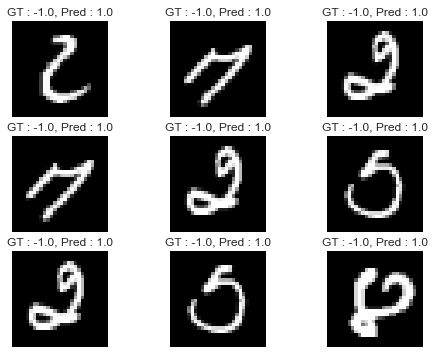

In [64]:
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 

for i in range(3):
    index = idx_offset + i
    for j in range(3):
        ax[i,j].imshow(X_train[idx_fp[index+j]].reshape(28,28),cmap='gray') 
        
        # we should not use x_train_with_dummy 

        # GT : ground truth ; Pred : predicted
        ax[i,j].set_title('GT : {0}, Pred : {1}'.format(str(y_train_0[idx_fp[index+j]]),str(y_hat_train_0[idx_fp[index+j]])))

        ax[i,j].set_axis_off() 

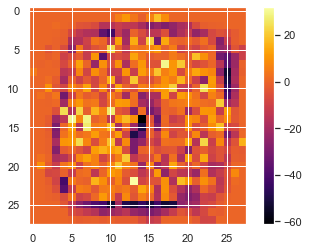

In [65]:
from matplotlib.colors import Normalize

w = bin_clf.coef_
w_matrix = w.reshape(28, 28)
#fig = plt.figure()
#plt.imshow(w_matrix, cmap='magma')
#plt.imshow(w_matrix, cmap='cividis')
#plt.imshow(w_matrix, cmap='viridis')
#plt.imshow(w_matrix, cmap='gray')
plt.imshow(w_matrix, cmap='inferno')

#plt.axis(False)
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.show()

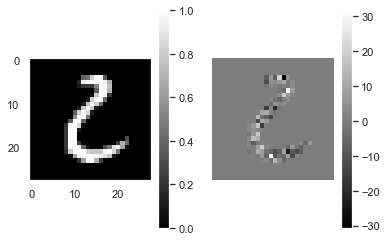

In [70]:
#print(idx_fp.shape)

activation = w * X_train[idx_fp[0]].reshape(1, -1)
lin_out = activation.reshape(28, 28)
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx_fp[0]].reshape(28, 28), cmap='gray')
plt.colorbar()

#lin_out[lin_out < 0]=0 # just set the value less than zero to zero

plt.subplot(1, 2, 2)
plt.imshow(lin_out, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()


Input to the signum

In [69]:
print(np.sum(lin_out)+bin_clf.intercept_)

[352.4343714]


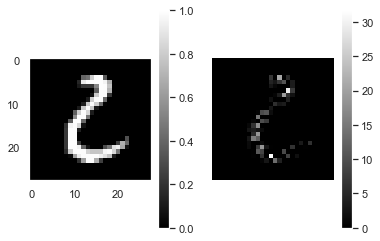

In [68]:
activation = w*(X_train[idx_tn[0]].reshape(1, -1))
lin_out = activation.reshape(28, 28)

plt.subplot(1, 2, 1)
plt.imshow(X_train[idx_tn[0]].reshape(28, 28), cmap='gray')
plt.colorbar()

# just set the value less than zero to zero
lin_out[lin_out < 0] = 0  
plt.subplot(1, 2, 2)
plt.imshow(lin_out, cmap='gray')

plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

Input to the signum

In [ ]:
print(np.sum(lin_out) + bin_clf.intercept_)

[352.4343714]
